# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:

- Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

- Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?


## Data:
The input variables (X) are (where Aleph uses only the first six):

- prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
- spheri: Sphericity of the event, i.e. how spherical it is.
- pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
- multip: Multiplicity of the jet (in a relative measure).
- bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
- ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
- energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
- cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
- phi: The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:

- isb: 1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):

- nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


## Task:

Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a Loss Function, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

- Author: Troels C. Petersen (NBI)
- Student following this exercise: Jackson Han

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

Possible other packages to consider: cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

- r = np.random:

This line creates a shorthand r for the numpy.random module. The numpy.random module contains functions for generating random numbers. By assigning it to r, the rest of the code can use r to access these functions.

- r.seed(42):

This line sets the seed for NumPy's random number generator to 42. A seed is a starting point for the sequence of random numbers that will be generated. Using the same seed ensures that the sequence of random numbers is reproducible. In other words, every time you run this code, the random numbers generated will be the same.

- SavePlots = False:

This line initializes a variable SavePlots with the Boolean value False. This variable is likely used later in the code to determine whether to save the plots that are created. If SavePlots is True, the plots will be saved; if False, the plots will not be saved.

- plt.close('all'):

This line closes all open Matplotlib figures. plt is a module from Matplotlib, a plotting library. plt.close('all') is a way to ensure that no figures are open before the code starts generating new plots. This can be helpful in managing memory or avoiding clutter from previously opened plots.

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong


The evaluate function you've provided is designed to assess the performance of a classifier in the context of identifying b-quark jets. Let's break down what this function does:

- Function Definition:

def evaluate(bquark):

This line defines a function named evaluate that takes one argument, bquark. bquark is expected to be a list or array containing the predictions made by your classification algorithm.

- Initializing the Confusion Matrix:

N = [[0,0], [0,0]]

This line initializes a confusion matrix N, which is a 2x2 matrix (list of lists in Python). Each element of this matrix will be used to count the number of true negatives, false positives, false negatives, and true positives.

- Iterating Over Predictions:

The for loop (for i in np.arange(len(isb)):) iterates over the indices of the isb array. The isb array is not defined in this snippet but is presumably a list or array containing the actual labels (truth values) for whether a jet is from a b-quark or not.

- Updating the Confusion Matrix:

Within the loop, there are four if statements, each updating a different element of the confusion matrix N based on the combination of predicted (bquark[i]) and actual (isb[i]) values.

N[0][0]: True Negatives (TN) - both predicted and actual values are 0.

N[0][1]: False Negatives (FN) - predicted value is 0, but actual value is 1.

N[1][0]: False Positives (FP) - predicted value is 1, but actual value is 0.

N[1][1]: True Positives (TP) - both predicted and actual values are 1.

- Calculating Fraction Wrong and Accuracy:

fracWrong = float(N[0][1]+N[1][0])/float(len(isb))

This line calculates the fraction of wrong predictions by summing the false negatives and false positives, then dividing by the total number of predictions.

accuracy = 1.0 - fracWrong

This line calculates the accuracy by subtracting the fraction of wrong predictions from 1.

- Returning Results:

return N, accuracy, fracWrong

The function returns the confusion matrix N, the accuracy, and the fraction of wrong predictions.

In summary, the evaluate function is a standard approach to assess a classification model's performance by using a confusion matrix and calculating the accuracy and error rate.

# Main program start:

In [4]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)    # For faster running
#data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# Kinematics (energy and direction) of the jet:
energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']

# Classification variables (those used in Aleph's NN):
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']

# Aleph's NN score:
nnbjet = data['nnbjet']

# Truth variable whether it really was a b-jet or not (i.e. target)
isb    = data['isb']

# Inspect the data:

Define the histogram range and binning (important - programs are generally NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

## Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [6]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]


The two variables prob_b and bqvjet in your dataset are related to the identification of b-quark jets, but they represent different aspects:

- prob_b (Probability of being a b-jet):

This variable represents the probability that a jet is a b-quark jet based on the trajectories of the particles (or tracks) within the jet pointing back to the collision vertex.

Essentially, prob_b is a measure of how likely it is that the jet originated from a b-quark, considering the alignment of the tracks in the jet with the point where particles collided and were produced. In particle physics, b-quarks have a longer lifetime than other quarks, which results in a measurable displacement of the decay vertex from the collision point. The alignment and geometry of these tracks are key indicators in identifying b-quark jets.

- bqvjet (b-quark vertex of the jet):

This variable is related to the probability of having a detached vertex associated with the jet, which is a characteristic feature of b-quark jets.

A detached vertex occurs when the particles produced by the decay of a b-quark travel a measurable distance before they themselves decay into other particles. This leads to a vertex (a point where tracks appear to emanate from) that is visibly separated from the primary collision vertex. bqvjet quantifies the likelihood of such a scenario. It's a crucial factor in b-quark jet identification because b-quarks, due to their relatively long lifetime (in the context of particle physics), can travel a small but detectable distance before decaying, unlike lighter quarks that decay almost instantaneously.



In summary, while both prob_b and bqvjet are probabilities used to identify b-quark jets, prob_b focuses on the alignment of the particle tracks with the collision vertex, and bqvjet focuses on the existence and characteristics of a detached vertex. Both are important in the context of particle physics for identifying jets that result from b-quarks.

## Produce 1D figures:

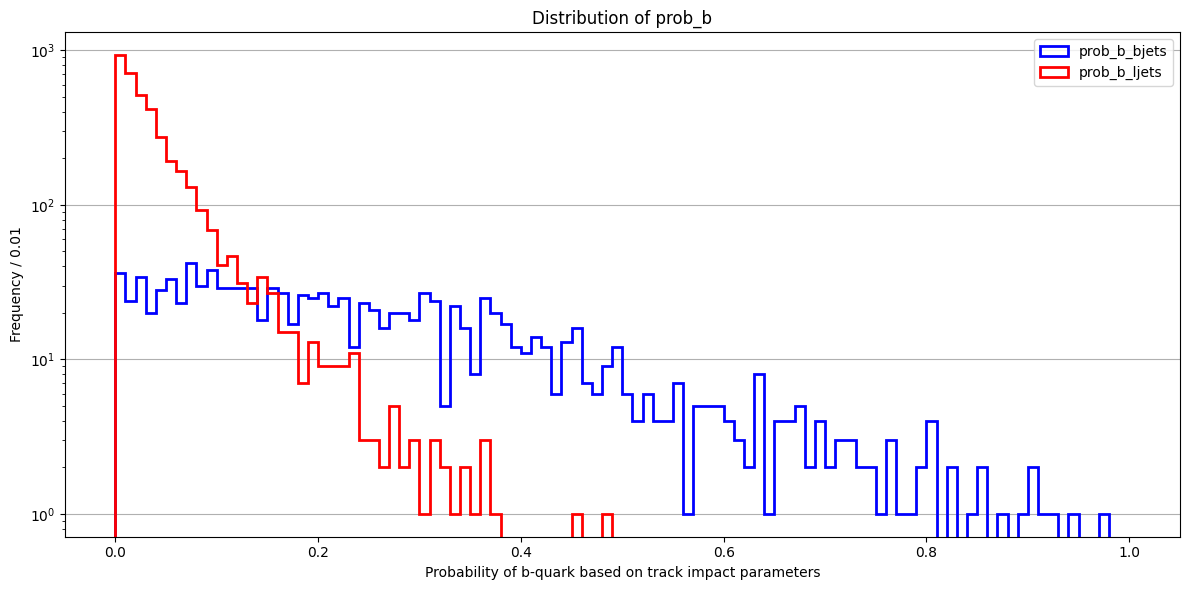

In [7]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

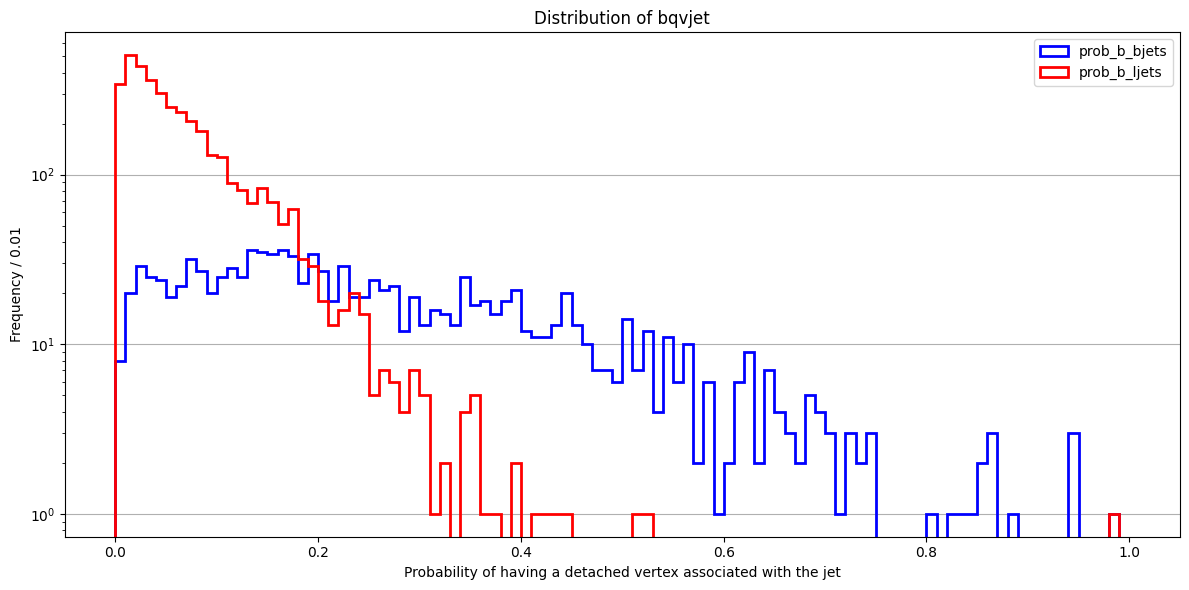

In [8]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_bqvjet_bjets = ax.hist(bqvjet_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_bqvjet_ljets = ax.hist(bqvjet_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of having a detached vertex associated with the jet")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of bqvjet")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

## Produce 2D figures:

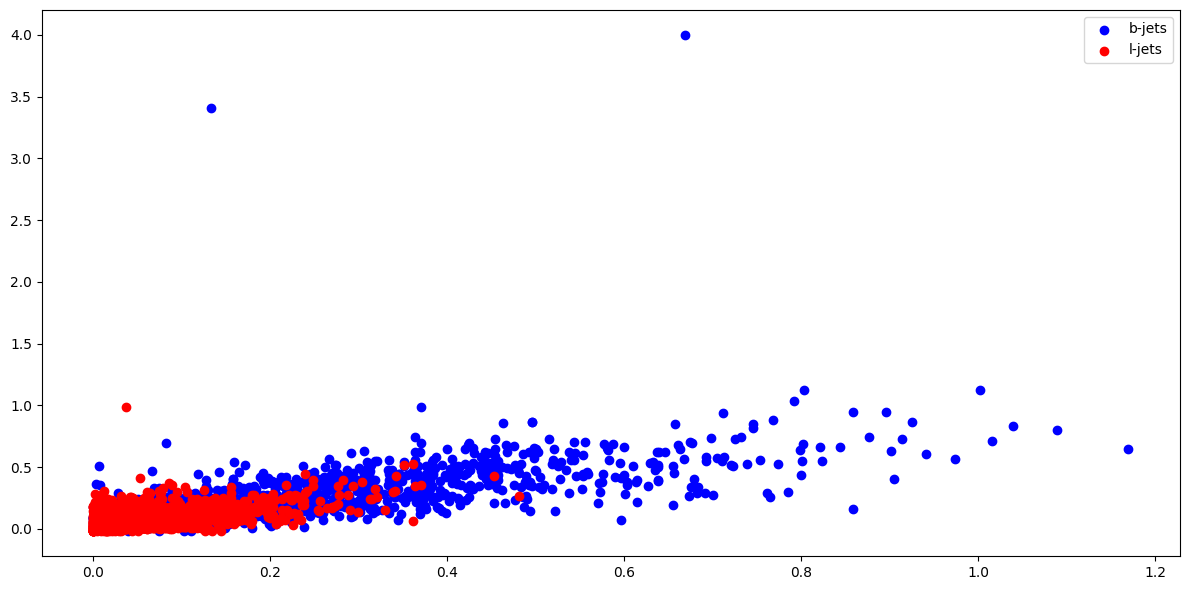

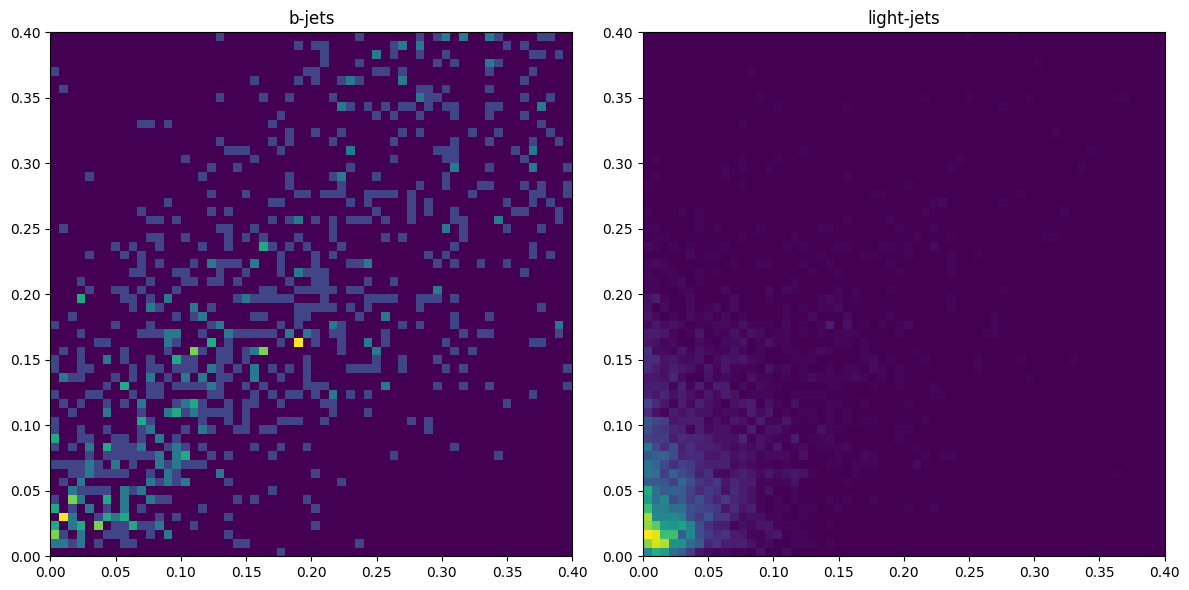

In [9]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()
fig2.show()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[60,60], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[60,60], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()
fig3.show()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

From the scatter plot, it is evident that cases with a probability of prob_b higher than 0.2 are more likely to be associated with b-quark jets. This relationship between prob_b and bqvjet holds true for b-jets but not for l-jets. This is only the situation between two variables. Since there are six variables, let's analysit their relations now. As the suggestions from the teacher: Start by plotting the six "Aleph classification variables" for signal and background, and see which seems to separate most. Possibly draw ROC curves for all of these separately, to quantify this.

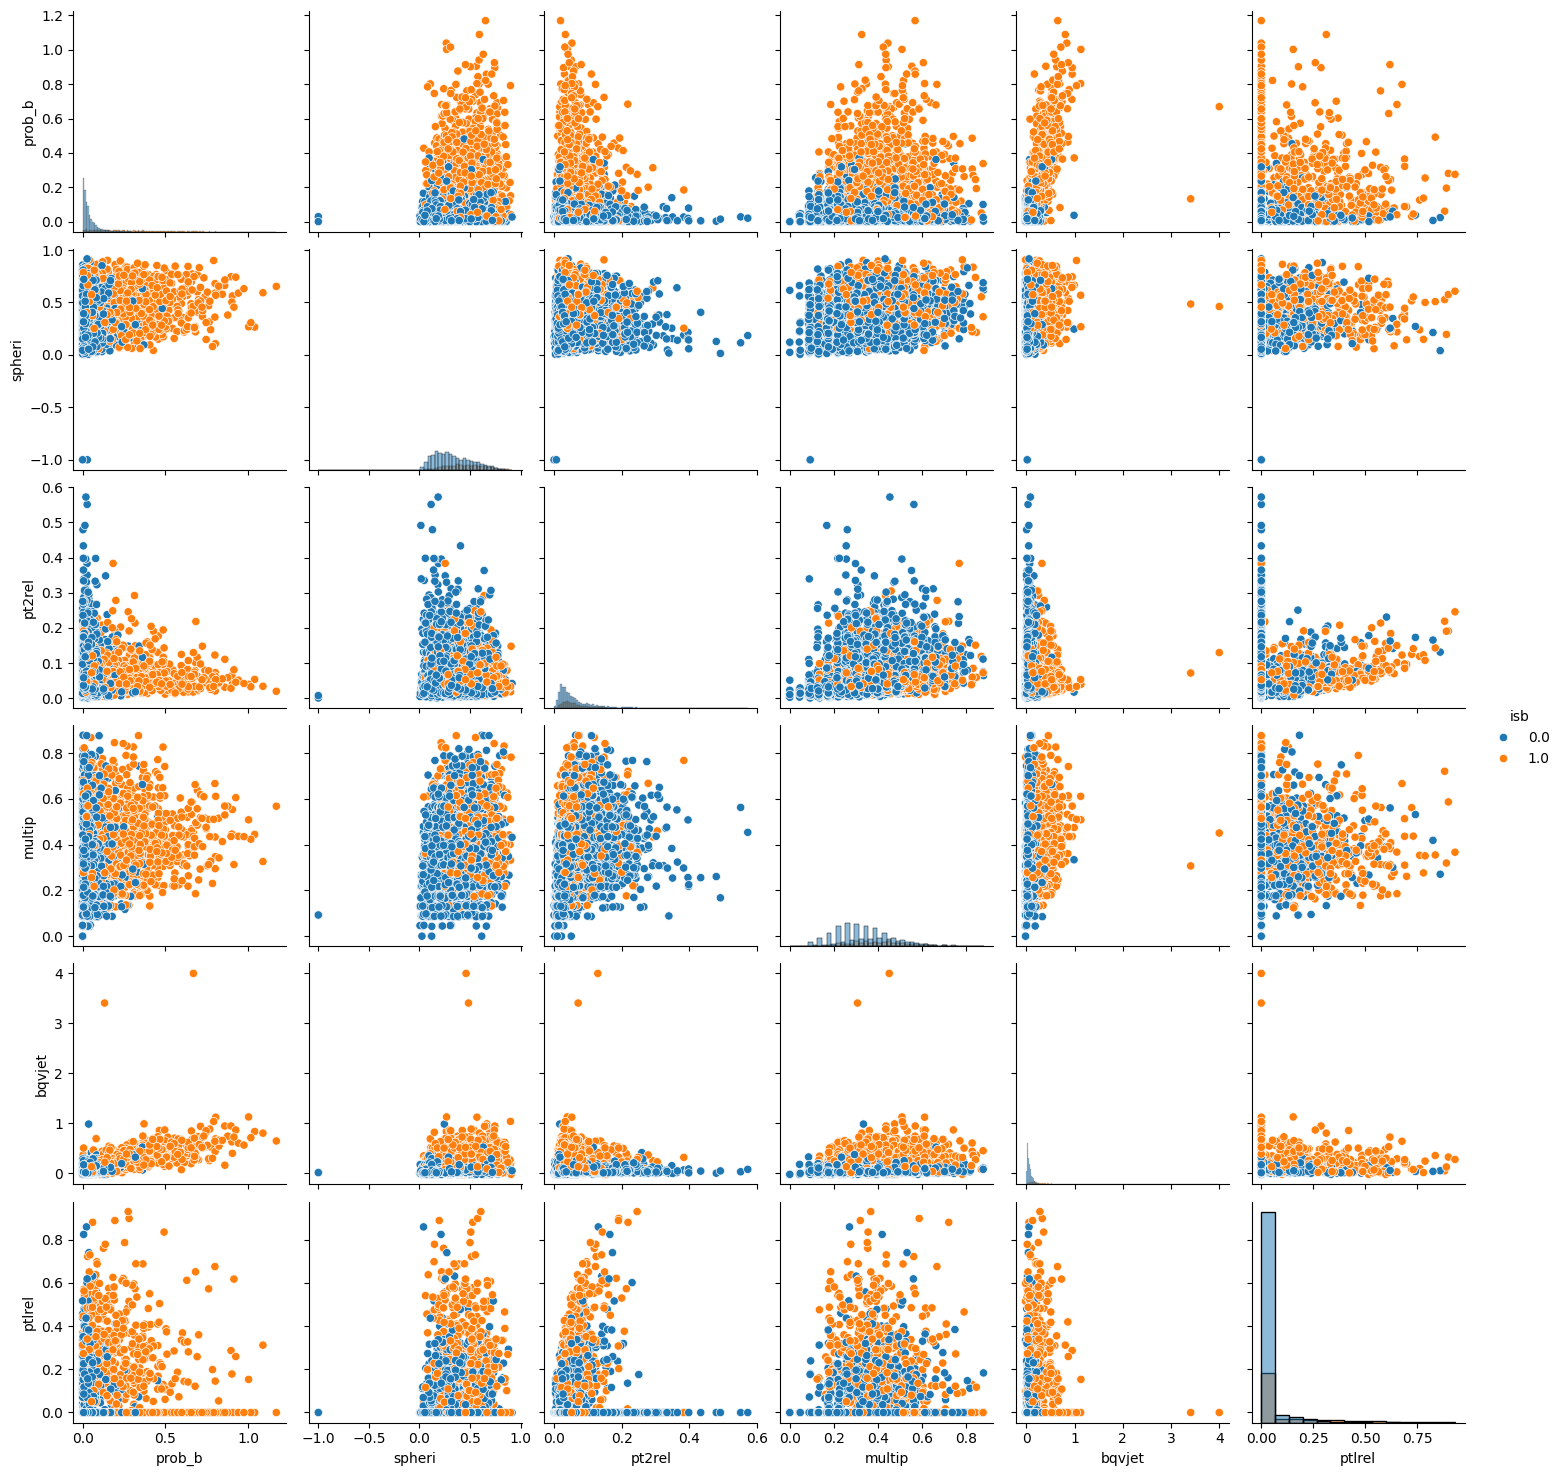

In [10]:
# 6x6 plot of the variable distributions (diagonal) and their mutual correlations (off-diagonal):
import pandas as pd
df = pd.DataFrame(data)                                        # Make the data into a DataFrame
df = df.drop(['energy','cTheta','phi','nnbjet'], axis=1)       # Drop the irrelevant variables

import seaborn as sns
sns.pairplot(df, hue="isb", diag_kind='hist')

          prob_b    spheri    pt2rel    multip    bqvjet    ptlrel       isb
prob_b  1.000000  0.215843 -0.044106  0.161979  0.750507  0.178093  0.651354
spheri  0.215843  1.000000 -0.044416  0.245822  0.197456  0.068243  0.278414
pt2rel -0.044106 -0.044416  1.000000  0.309295 -0.020872  0.081342  0.000299
multip  0.161979  0.245822  0.309295  1.000000  0.213691  0.057460  0.229967
bqvjet  0.750507  0.197456 -0.020872  0.213691  1.000000  0.123497  0.563827
ptlrel  0.178093  0.068243  0.081342  0.057460  0.123497  1.000000  0.299047
isb     0.651354  0.278414  0.000299  0.229967  0.563827  0.299047  1.000000


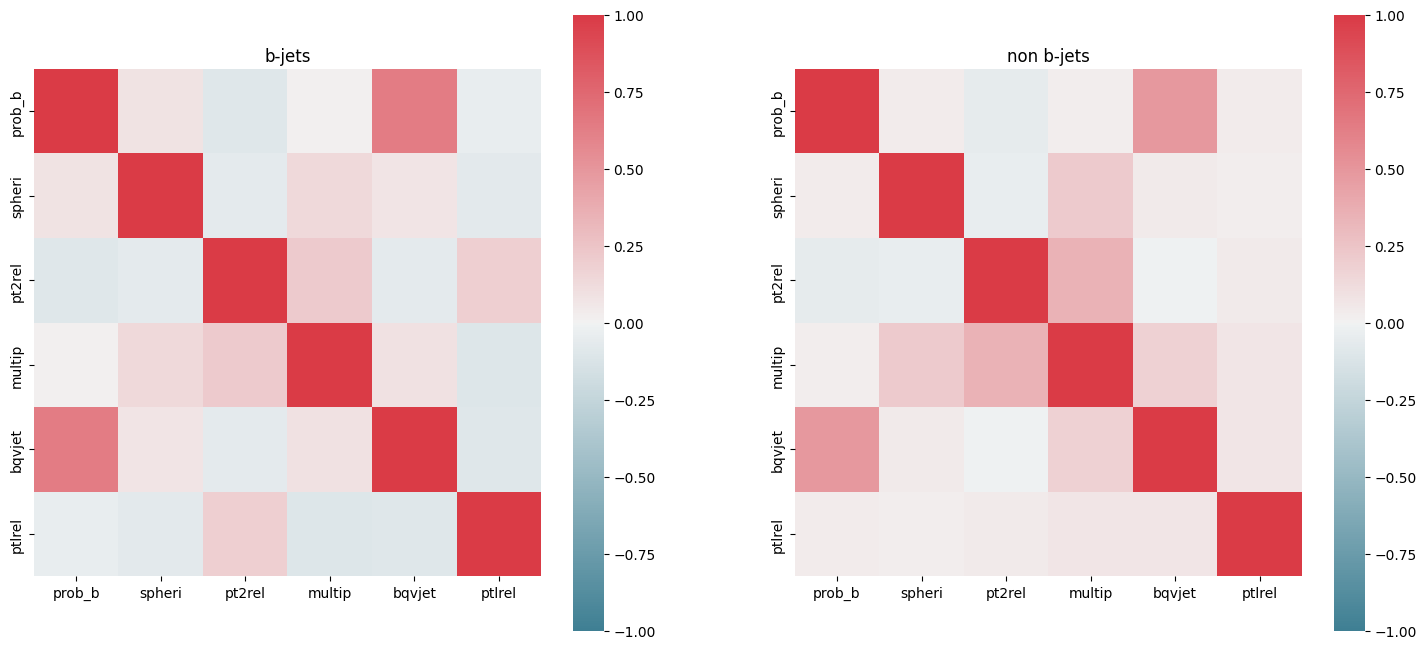

In [11]:
# Plot of the variable correlation (here Pearson, i.e. linear):

# First print the correlations for ALL events:
print(df.corr(method='pearson'))
# Divide data into b-jets and non-b-jets:
df_b = df.loc[df['isb'] == 1].drop(['isb'], axis=1)
df_l = df.loc[df['isb'] == 0].drop(['isb'], axis=1)

# Make two separate correlation plots, also to see differences:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(df_b.corr(), mask=np.zeros_like(df_b.corr(), dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0,
            square=True, ax=ax[0])
ax[0].set_title('b-jets')

sns.heatmap(df_l.corr(), mask=np.zeros_like(df_l.corr(), dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0,
            square=True, ax=ax[1])
ax[1].set_title('non b-jets');


## Comments on plots:

As can be seen, the variables correlate similarly between the two types of jets. In particular 'prob_b' and 'bqvjet' are very correlated, which is the reason why performance doesn't increase a lot, when both of these powerful variables are included: They hold similar power, which can only be used once!

The variable 'ptlrel' is not very correlated to any other variables, which means that it contributes no matter which other variables are included. Of course in the end, one wants to include all variables.

# Selection: (brute force looping over selection values to get "optimal" selection)

In [12]:
# Here I make a range of values (min, max) from which I choose (randomly - more on that) from:
range_loose_prob_b = [0.08, 0.11]
range_tight_prob_b = [0.16, 0.21]
range_loose_bqvjet = [0.13, 0.18]
range_tight_bqvjet = [0.28, 0.40]
range_loose_ptlrel = [0.20, 0.40]
range_tight_ptlrel = [0.45, 0.65]

# The current best (i.e. lowest) fraction wrong. Set high initially, and lowered by better selections:
fracWrong_min = 0.999

# Try several times (here 100):
for Ntest in range(100) :

    # Choose random selection and test it:
    loose_prob_b = r.uniform(range_loose_prob_b[0], range_loose_prob_b[1])
    tight_prob_b = r.uniform(range_tight_prob_b[0], range_tight_prob_b[1])
    loose_bqvjet = r.uniform(range_loose_bqvjet[0], range_loose_bqvjet[1])
    tight_bqvjet = r.uniform(range_tight_bqvjet[0], range_tight_bqvjet[1])
    loose_ptlrel = r.uniform(range_loose_ptlrel[0], range_loose_ptlrel[1])
    tight_ptlrel = r.uniform(range_tight_ptlrel[0], range_tight_ptlrel[1])

    bquark=[]
    for i in np.arange(len(prob_b)):
        if   (prob_b[i] > tight_prob_b) : bquark.append(1)
        elif (bqvjet[i] > tight_bqvjet) : bquark.append(1)
        elif (ptlrel[i] > tight_ptlrel) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (bqvjet[i] > loose_bqvjet)) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        elif ((bqvjet[i] > loose_bqvjet) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        else : bquark.append(0)

    N, accuracy, fracWrong = evaluate(bquark)

    # Flag/print best selection(s):
    if (fracWrong < fracWrong_min) :
        print("\nRESULT OF TESTING MANY SELECTION CUTS:")
        print("  First number is my estimate, second is the MC truth:", Ntest)
        print("  True-Negative (0,0)  = ", N[0][0])
        print("  False-Negative (0,1) = ", N[0][1])
        print("  False-Positive (1,0) = ", N[1][0])
        print("  True-Positive (1,1)  = ", N[1][1])
        print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
        print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

        fracWrong_min = fracWrong
        print("  GOT A NEW MINIMUM.... GREAT!")
        print("  loose_prob_b = ", loose_prob_b)
        print("  tight_prob_b = ", tight_prob_b)
        print("  loose_bqvjet = ", loose_bqvjet)
        print("  tight_bqvjet = ", tight_bqvjet)
        print("  loose_ptlrel = ", loose_ptlrel)
        print("  tight_ptlrel = ", tight_ptlrel)


RESULT OF TESTING MANY SELECTION CUTS:
  First number is my estimate, second is the MC truth: 0
  True-Negative (0,0)  =  3650
  False-Negative (0,1) =  373
  False-Positive (1,0) =  172
  True-Positive (1,1)  =  805
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.109
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.891
  GOT A NEW MINIMUM.... GREAT!
  loose_prob_b =  0.09123620356542088
  tight_prob_b =  0.2075357153204958
  loose_bqvjet =  0.16659969709057026
  tight_bqvjet =  0.35183901810364443
  loose_ptlrel =  0.23120372808848733
  tight_ptlrel =  0.48119890406724053

RESULT OF TESTING MANY SELECTION CUTS:
  First number is my estimate, second is the MC truth: 4
  True-Negative (0,0)  =  3615
  False-Negative (0,1) =  337
  False-Positive (1,0) =  207
  True-Positive (1,1)  =  841
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.1088
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.8912
  GOT A NEW MINIMUM.... GREAT!
  loose_prob_

## Compare with NN-approach from 1990'ies, (this is the result calculated by others using NN):


In [13]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3700
  False-Negative (0,1) =  372
  False-Positive (1,0) =  122
  True-Positive (1,1)  =  806
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0988
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9012


# Comments on example solution 1:

This solution simply expands on the first solution by searching for better parameters of the first solution. There are six parameters, and one can either do nested loops over all six, or... choose points at random! We'll discuss these approaches more.

This solution improves the wrong fraction from 0.112 to 0.1078, which is marginally better, though still not close to the Aleph NN solution of 0.0988.

## Solution 2 - Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_graphviz
import pandas as pd
import graphviz
from IPython.display import SVG
from graphviz import Source
from sklearn import tree
from ipywidgets import interactive
from IPython.display import display

In [15]:
data_xx = np.column_stack((prob_b,spheri,pt2rel,multip,bqvjet,ptlrel))
data_yy = isb
X = pd.DataFrame(data_xx, columns=['prob_b', 'spheri','pt2rel','multip','bqvjet','ptlrel'])
y = pd.Series(data_yy, name='b-quark')

In [16]:
def plot_tree(depth, Nmin):
    tree_clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=Nmin)
    tree_clf.fit(X, y)
    graph = Source(tree.export_graphviz(tree_clf, out_file=None, filled = True))
    display(SVG(graph.pipe(format='svg')))
    return tree_clf

In [17]:
decision_plot = interactive(plot_tree, depth=(1,7), Nmin=(1,50))
display(decision_plot)

interactive(children=(IntSlider(value=4, description='depth', max=7, min=1), IntSlider(value=25, description='…

In [18]:
tree_clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=25)
tree_clf.fit(X, y)
bquark = tree_clf.predict(X)

N, accuracy, fracWrong = evaluate(bquark)
print("\nDecision Tree BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


Decision Tree BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3654
  False-Negative (0,1) =  303
  False-Positive (1,0) =  168
  True-Positive (1,1)  =  875
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0942
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9057999999999999


# Comment on example solution 2:

This solution - a Decision Tree (from SKlearn) - is fundamentally different, as it is mostly automated, though it is still simple. It improves the wrong fraction from 0.112 to 0.0942, which is significantly better than the Aleph NN solution of 0.0988.

However... this is because of overfitting! It makes special rules for subclasses that a statistically significant in this set, but not generally, and so it won't work as well on new data. That is why we split the data, when training, so that we have some data saved for testing the performance on "unseen" data.

# OK, LET'S RESTART THE WHOLE ANALYSIS PROCESS

In [19]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time



In [20]:
import pandas as pd
from pandas import Series, DataFrame

data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True))

variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


In [21]:
# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables)

  Variables used for training:  Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')



# Classify B-jets using LightGBM:

This is a solution example using LightGBM (tree based).


In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping

In [23]:
start=time.time()

# Split data set into training and test set and feed these to LightGBM:
# We choose a 75:25 division here. Dataset is shuffeled before the split.
# By using a number (42), it creates a random seed so you can rerun and obtain the same result.
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'num_leaves': 2,         # Set a maximum tree leaves to avoid overfitting
    'verbose':-1,            # Suppress some output
}


In [24]:
# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N rounds.



Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.365218


In [25]:
# Make predictions:
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.
y_pred  = [1 if pred > 0.1 else 0 for pred in y_score]               # Classify b-quark yes or no (for comparison).

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

Time used by LightGBM: 157.9 ms



# Classify B-jets using MLPclassifier:

This is a solution example using MLPclassifier (NN based).

In [26]:
from sklearn.neural_network import MLPClassifier

start=time.time()
clf = MLPClassifier(max_iter=20000,
                    n_iter_no_change=100,           # Number of iterations without improvement before stopping
                    solver='adam',                  # Standard for minimising
                    activation='logistic',          # Standard function (but slightly slower)
                    hidden_layer_sizes=(10, 10),    # Size of network (same as ALEPH)
                    learning_rate='invscaling',     # Other options are "constant" and "adaptive"
                    random_state=42)
clf.fit(input_test, truth_test)

# Make predictions (NOTE: This "spits out" two columns!):
y_score_MLP = clf.predict_proba(input_test)

# Print the time usage:
end = time.time()
print(f"Time used by MLPClassifier: {(end-start)*1000:.1f} ms")

Time used by MLPClassifier: 1955.9 ms


Text(0, 0.5, 'True Positive Rate')

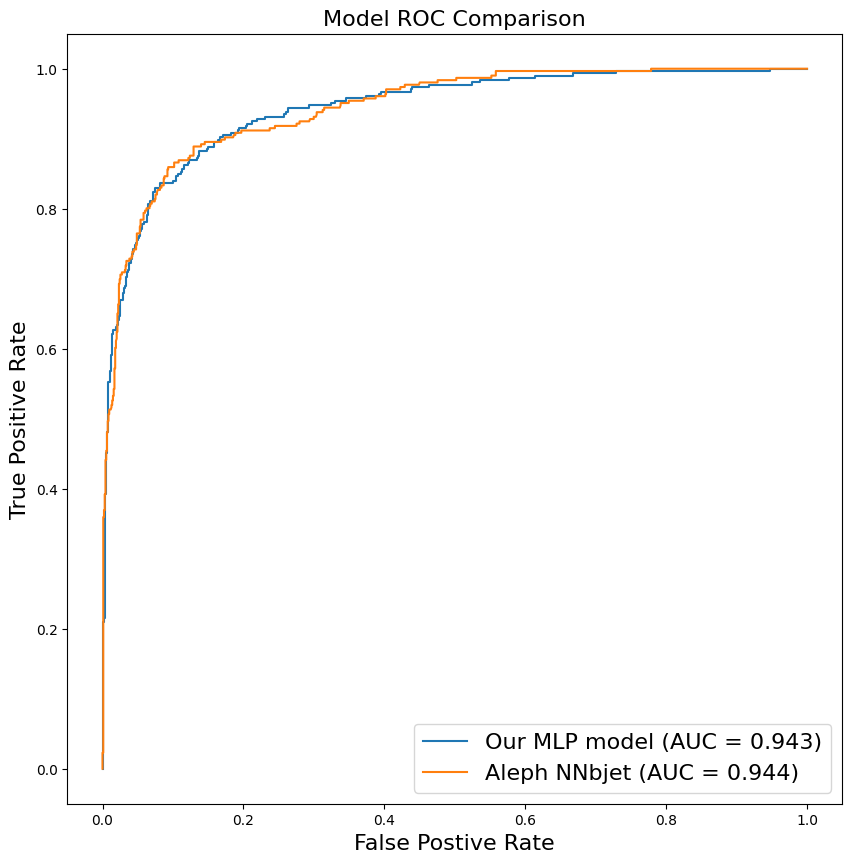

In [27]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score_MLP[:,1])              # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our MLP model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)


# Classify B-jets using TensorFlow:

This is a solution example using TensorFlow (NN based).

The example is built with inspiration from https://blog.cmgresearch.com/2020/09/06/tensorflow-binary-classification.html

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Always split your dataset into train and validation part. We choose a 75:25 division here. Shuffels dataset before split. By using a number (42), it creates a random seed so you can rerun and obtain the same result.
input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

# Create a NN. Loss function is BinaryCrossEntropy. Output layer has 1 node;the prediction for isb. Learning rate defaults to 0.001.
model = Sequential([
    Dense(6,activation='relu'),
    Dense(24,activation='relu'),
    Dense(12,activation='relu'),
    Dense(1, activation='sigmoid' )])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), y = np.array(truth_train), validation_data=(np.array(input_valid), np.array(truth_valid)), epochs = 7)
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset,
## namely input_valid and truth_valid.

--------- TRAINING ---------
Epoch 1/7


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_crossentropy: 0.5985 - loss: 0.6003 - val_binary_crossentropy: 0.5102 - val_loss: 0.5146
Epoch 2/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_crossentropy: 0.4085 - loss: 0.4090 - val_binary_crossentropy: 0.3182 - val_loss: 0.3231
Epoch 3/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_crossentropy: 0.2964 - loss: 0.2956 - val_binary_crossentropy: 0.2713 - val_loss: 0.2762
Epoch 4/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_crossentropy: 0.2765 - loss: 0.2774 - val_binary_crossentropy: 0.2591 - val_loss: 0.2642
Epoch 5/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_crossentropy: 0.2723 - loss: 0.2691 - val_binary_crossentropy: 0.2541 - val_loss: 0.2590
Epoch 6/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_crossentropy: 0.2645 - loss: 0.2652 - val_binary_crossentropy: 0.2532 - val_loss: 0.2583
Epoch 7/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_crossentropy: 0.2666 - loss: 0.2653 - val_binary_crossen

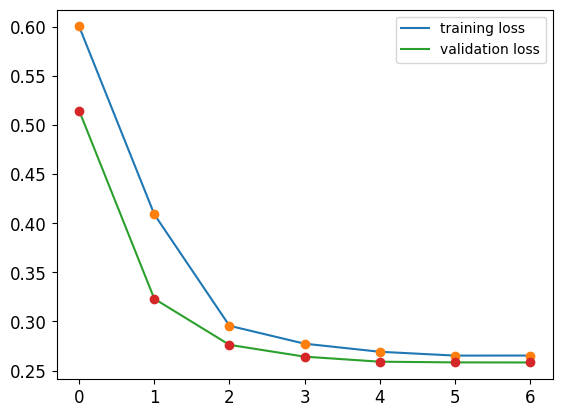

In [30]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [31]:
# Now make predictions on input_valid. Notice we're not giving it any truth values!
predictions = model.predict(input_valid)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


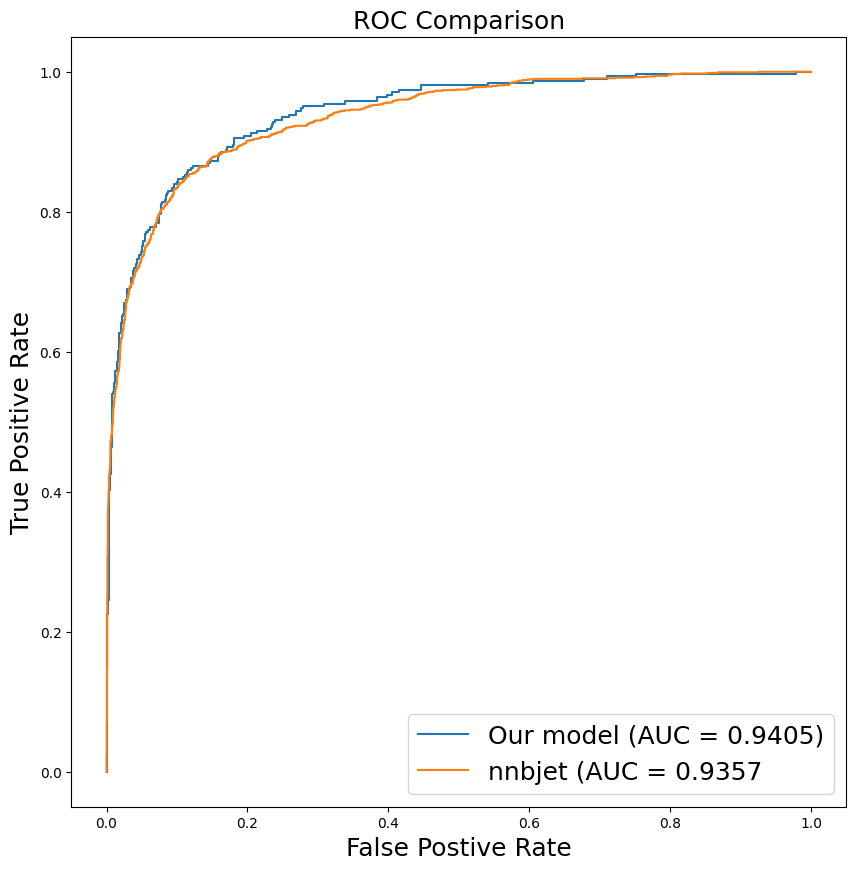

In [32]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)
plt.show()

#Classify B-jets using PyTorch:

This is a solution example using PyTorch (NN based).

The example is built with inspiration from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from scipy.special import expit

# PyTorch "specials":

PyTorch requires that we put this data into the pytorch-Dataset class, such that we can extract it during training.

PyTorch generally wants things to be written into functions and classes, which makes it slightly less easy to "just use", but once you get acquainted with this, PyTorch is a powerful and versatile tool.

In [35]:
# Training data:
class MyDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.input = X_data
        self.truth = y_data

    def __getitem__(self, index):
        return self.input[index], self.truth[index]

    def __len__ (self):
        return len(self.input)

# In pytorch, there is an additional step of turning your data into tensors:
train_data = MyDataset(torch.FloatTensor(np.array(input_train)),
                       torch.FloatTensor(np.array(truth_train)))
valid_data = MyDataset(torch.FloatTensor(np.array(input_valid)),
                       torch.FloatTensor(np.array(truth_valid)))

# We can now access input_train via train_data.input and truth_train via train_data.truth,
# and similarly for input_valid and truth_valid:
print(train_data.input[:2])    # Always check what your data looks like!
print(train_data.truth[:2])

tensor([[ 7.4200e-02,  3.9060e-01,  4.2900e-02,  4.1280e-01,  8.9100e-02,
         -3.0000e-04],
        [ 1.3700e-02,  6.9120e-01,  6.5200e-02,  3.9620e-01,  4.2000e-03,
         -3.0000e-04]])
tensor([0., 0.])


In [36]:
# Define the model:
class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()        # Here we define the layers.
        self.input_layer = nn.Linear(6, 24)     # In pytorch, you define the input and output edges explicitly.
        self.hidden_layer1 = nn.Linear(24, 24)
        self.hidden_layer2 = nn.Linear(24, 12)
        self.output_layer = nn.Linear(12, 2)
        self.relu = nn.ReLU()

    def forward(self, inputs):                  # Here we define how data passes through the layers.
        x = self.input_layer(inputs)            # Also here, pytorch is a bit more explicit in defining the layers and activation function separately
        x = self.relu(x)
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [37]:
# Training loop:
def Train(model, optimizer, loss_function, train_loader, validation_loader, device, epochs):
    validation_loss = []
    training_loss   = []
    model.train()
    for e in range(0, epochs):
        epoch_loss = 0
        n_minibatches = 0
        for input_train_batch, truth_train_batch in train_loader:
            input_train_batch, truth_train_batch = input_train_batch.to(device), truth_train_batch.to(device)
            optimizer.zero_grad()
            prediction = model(input_train_batch)  # This asks our model to produce predictions on the training batch
            loss = loss_function(prediction, truth_train_batch.long())  # This calculates the loss
            loss.backward()                                             # This initiates the backpropagation
            optimizer.step()                                            # Updates the paramaters
            epoch_loss += loss.item()                                   # Extracts the loss value, such that mean loss can be calculated later (see 6 lines down)
            n_minibatches += 1

        # Now that the model have trained 1 epoch, we evaluate the model on the validation set:
        valid_loss = Validate(model, validation_loader, device, loss_function)
        validation_loss.append(valid_loss)
        training_loss.append(epoch_loss/n_minibatches)
        print('EPOCH: %s | training loss: %s  | validation loss: %s'%(e+1,round(epoch_loss/n_minibatches,3), round(valid_loss, 3)))
    return training_loss, validation_loss


def Validate(model, validation_loader, device, loss_function):
    model.eval()
    n_batches  = 0
    validation_loss = 0
    with torch.no_grad():
        for input_valid_batch, truth_valid_batch in validation_loader:
            input_valid_batch, truth_valid_batch = input_valid_batch.to(device), truth_valid_batch.to(device)
            prediction = model(input_valid_batch)
            loss = loss_function(prediction, truth_valid_batch.long())
            validation_loss += loss.item()
            n_batches += 1
    validation_loss = validation_loss/n_batches
    return validation_loss


def Predict(model, prediction_loader, device):
    model.eval()
    predictions = []
    print('PREDICTING!')
    with torch.no_grad():
        for input_pred_batch, _ in validation_loader:
            input_pred_batch = input_pred_batch.to(device)
            prediction = model(input_pred_batch)
            predictions.extend(prediction.numpy())
    print('Done Predicting!')
    return predictions

In [38]:
# Now everything is ready, and we thus define the optimisation (hyper-) parameters:
learning_rate = 1e-3      # The step size in the direction of "good" from stocastic gradient descent (important!)
batch_size    = 32        # The size of the batches used for each of the stocastic gradient descent calculations
n_epochs      = 8         # Number of epochs, i.e. times that we run through the entire dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OurModel()
model.to(device)       # Mount the model to the selected device. Either CPU or GPU.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=valid_data, batch_size=batch_size)

training_loss, validation_loss = Train(model, optimizer, loss_function, train_loader, validation_loader, device, n_epochs)

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 302: Error loading CUDA libraries. GPU will not be used. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


EPOCH: 1 | training loss: 0.541  | validation loss: 0.439
EPOCH: 2 | training loss: 0.311  | validation loss: 0.264
EPOCH: 3 | training loss: 0.263  | validation loss: 0.249
EPOCH: 4 | training loss: 0.262  | validation loss: 0.251
EPOCH: 5 | training loss: 0.264  | validation loss: 0.255
EPOCH: 6 | training loss: 0.267  | validation loss: 0.252
EPOCH: 7 | training loss: 0.264  | validation loss: 0.246
EPOCH: 8 | training loss: 0.258  | validation loss: 0.26


This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, namely input_valid and truth_valid.

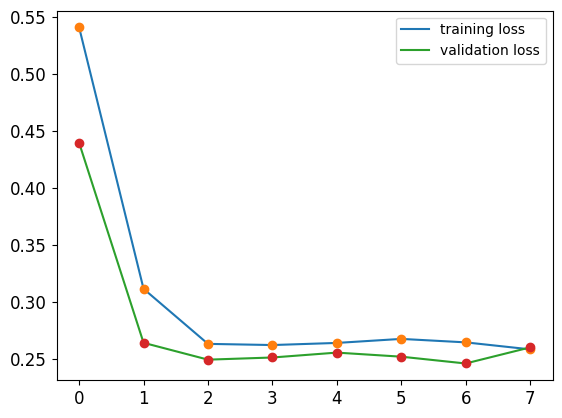

In [39]:
fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [40]:
predictions = Predict(model, validation_loader, device) # Make predictions on input_valid. Notice we're not giving it any truth values!
print("\nRaw predictions: \n", predictions[:2])

# The output of our model is raw "logits" from the final output layer.
# This means it produces a pseudo score for each class (a score for 0 and a score for 1).
# The function "expit" converts this logit to a number in [0,1].
# We then combine the logit scores such that our_score = (1_score) / (1_score + 0_score).
predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
predictions['not_bquark'] = expit(predictions['not_bquark'])
predictions['bquark'] = expit(predictions['bquark'])
predictions = predictions['bquark']/(predictions['bquark'] + predictions['not_bquark'])

print("\nTransformed predictions: \n", predictions[:2])

PREDICTING!
Done Predicting!

Raw predictions: 
 [array([-2.3275685,  0.9400156], dtype=float32), array([ 0.7078544, -0.98847  ], dtype=float32)]

Transformed predictions: 
 0    0.890014
1    0.288176
dtype: float32


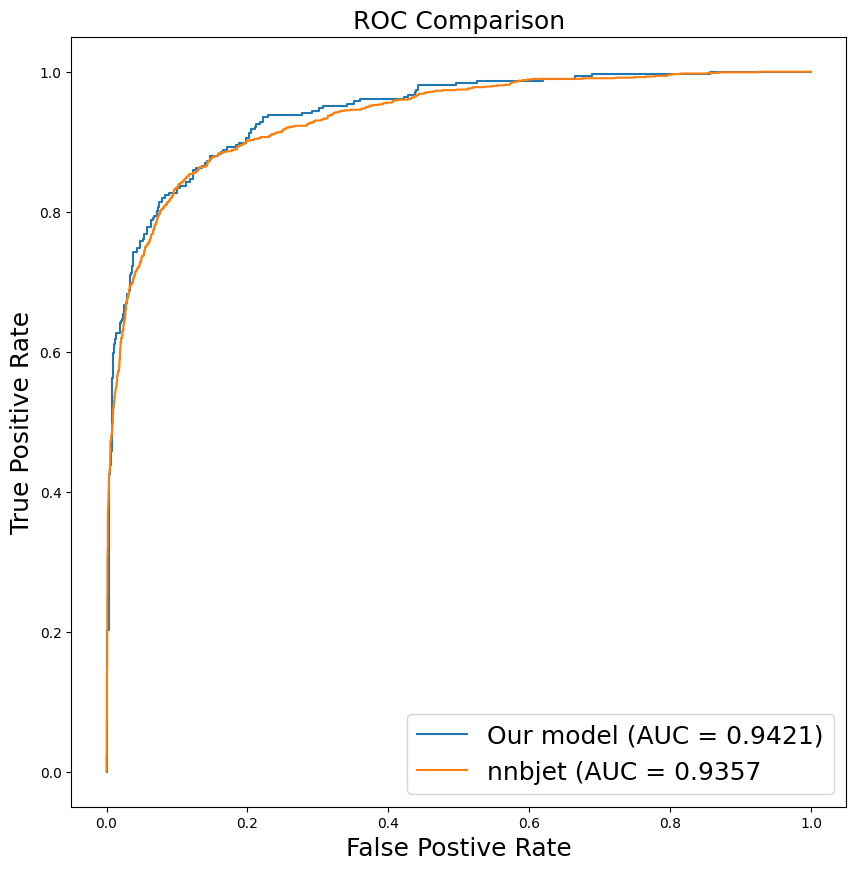

In [41]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)
plt.show()

# HyperparameterOptimization

Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, y_pred, which is "closest possible" to the target variable, y. The "closest possible" is left to the user to define in a Loss Function.

- Author: Arnau Morancho Tardà (NBI) and Rasmus Ørsøe (NBI)

- Student following this exercise: Jackson Han

In [42]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time

r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Read the data

We choose input and target variables:

- 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type. They are good variables for using regression algorithms. In particular, we will predict the energy, which is not cyclic and therefore less considerations need to take into account. We encourage you trying or thinking about how to solve the cyclic problem for 'cTheta' and 'phi'.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input and truth:

In [44]:
import pandas as pd
from pandas import Series, DataFrame

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev500000.csv', names=True))

variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


In [45]:
# Decide on which variables to use for input (X) and what defines the label (Y):

input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data = data[input_variables]
truth_data = data['energy']
print('Variables user for tarining: ', input_variables)

Variables user for tarining:  Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


# Regression using LightGBM:

This is a solution example using LightGBM (tree based).

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import early_stopping
from scipy.stats import gaussian_kde

In [47]:
X_train, X_test, y_train, y_test = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

In [48]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'regression',   # The outcome is binary, b-quark or not
    'num_leaves': 10,         # Set a maximum tree leaves to avoid overfitting
    'learning_rate': 0.03,
    'verbose':-1,            # Suppress some output
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                callbacks=[early_stopping(40)])     # Stops if no improvement is seen in N rounds.

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[535]	valid_0's l2: 27.3787


In [49]:
# Make predictions:
y_pred_lgbm = gbm.predict(X_test)  # Scores are floats in the range ]0,1[.
# accuracy check
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 27.38
RMSE: 5.23


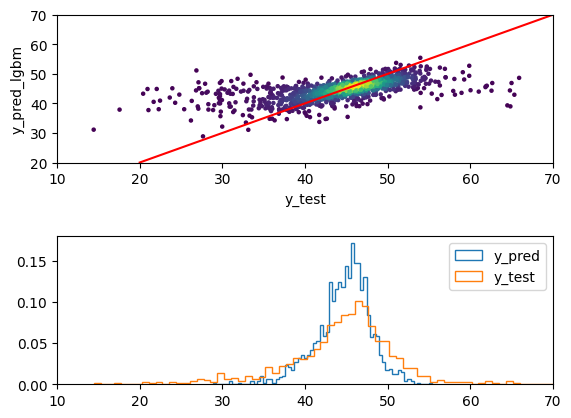

In [50]:
x = np.linspace(20,70,100)
y = x

# Calculate the point density
xy = np.vstack([y_test,y_pred_lgbm])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(2)
axs[0].scatter(y_test,y_pred_lgbm, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_test')
axs[0].set_ylabel('y_pred_lgbm')
axs[0].set_xlim([10, 70])  # Set the x-axis limit to 70
axs[0].set_ylim([20, 70])  # Set the y-axis limit to 70

axs[1].hist(y_pred_lgbm, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_test,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()
axs[1].set_xlim([10, 70])  # Set the x-axis limit to 70


# Adjust the spacing
plt.subplots_adjust(hspace=0.5)  # Adjust this value to increase or decrease the space

plt.show()

## Optimization LightGBM
### Random Search

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, poisson,uniform
import random

In [52]:
gbm = lgb.LGBMRegressor()
# specify parameters and distributions to sample from
parameters_RandomSearch = {'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base= 10, num=1000)),#random.uniform(1e-6, 1e-3),
                           'num_leaves': poisson(50),
                           'max_depth': randint(1, 50),
                           'n_estimators' : poisson(500),
                           #'learning_rate': uniform(),
                          }

In [53]:
# run randomized search
n_iter_search = 20
RandomSearch = RandomizedSearchCV(gbm,
                                  param_distributions=parameters_RandomSearch,
                                  n_iter=n_iter_search,
                                  #scoring = 'neg_mean_absolute_error',
                                  cv=5,
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [54]:
# fit the random search instance
RandomSearch.fit(X_train, y_train);


In [55]:
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")


Random Search: 	Best parameters:  {'learning_rate': np.float64(0.0080015515686935), 'max_depth': 29, 'n_estimators': 477, 'num_leaves': 52} , Best scores: 0.319


In [56]:
RandomSearch_results.head(5)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.535974,0.051199,0.012947,0.002799,0.008002,29,477,52,"{'learning_rate': 0.0080015515686935, 'max_dep...",0.327811,...,0.318619,0.025473,1,0.598594,0.617153,0.625371,0.617848,0.617428,0.615279,0.008888
1,0.327870,0.018375,0.010203,0.000806,0.013409,11,497,41,"{'learning_rate': 0.013409063047265076, 'max_d...",0.319200,...,0.314340,0.025799,3,0.618859,0.647671,0.652751,0.646276,0.649067,0.642925,0.012224
2,0.071744,0.033130,0.005178,0.000252,0.020682,2,508,50,"{'learning_rate': 0.020681718420316363, 'max_d...",0.265225,...,0.257827,0.018190,13,0.306856,0.336136,0.330224,0.326599,0.333532,0.326669,0.010411
3,0.435009,0.047975,0.013475,0.004034,0.044660,16,481,52,"{'learning_rate': 0.04466022999290484, 'max_de...",0.289047,...,0.276242,0.017636,8,0.882498,0.897703,0.894685,0.890180,0.890406,0.891094,0.005134
4,0.110435,0.055592,0.006562,0.001348,0.015327,3,528,49,"{'learning_rate': 0.015326976475282632, 'max_d...",0.271966,...,0.274578,0.024475,9,0.356188,0.380704,0.389837,0.384978,0.378334,0.378008,0.011593


In [57]:
clf_RandomSearch = RandomSearch.best_estimator_


# Make predictions:
y_pred_lgbm_rand_opt = clf_RandomSearch.predict(X_test)  # Scores are floats in the range ]0,1[.
# accuracy check
mse_lgb_rand_opt = mean_squared_error(y_test, y_pred_lgbm_rand_opt)
rmse_lgb_rand_opt = mse_lgb_rand_opt**(0.5)

print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')

RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717


# Regression using TensorFlow

This is a solution example using TensorFlow (NN based).

Something important for neural networks is that all the input data should be normalized or standarized. As mentioned before all the input data is already prepared but the output (energy) is not. So as an example we show one way of using one of this transorfations (QuantileTransformer). After we have predict our target we can do the inverse transformation to get the expected scale.

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import QuantileTransformer
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import torch
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam


In [64]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')  #Use GPU

Something important for neural networks is that all the input data should be normalized or standarized. As mentioned before all the input data is already prepared but the output (energy) is not. So as an example we show one way of using one of this transorfations (QuantileTransformer). After we have predict our target we can do the inverse transformation to get the expected scale.

In [65]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
y_norm = qt.fit_transform(truth_data.array.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(input_data, y_norm, test_size=0.25, random_state=42)

In [67]:
def base_model(**kwargs):
    nn_reg = tf.keras.models.Sequential([
        Dense(units=n_inputs, input_dim=n_inputs, kernel_initializer='normal', activation='relu'),
        Dense(n_hidden1, activation='relu', kernel_initializer='normal'),
        BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
        Dense(n_hidden2, activation='relu', kernel_initializer='normal'),
        BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
        Dense(n_hidden3, activation='relu', kernel_initializer='normal'),
        BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
        Dense(n_outputs, kernel_initializer='normal')
    ])

    nn_reg.compile(loss='mean_squared_error', optimizer='adam')
    return nn_reg

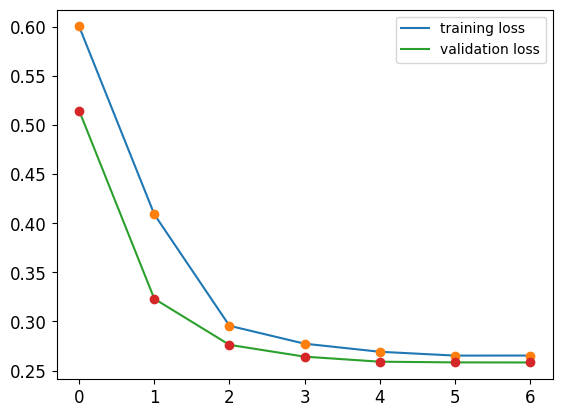

In [68]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [70]:
from scikeras.wrappers import KerasRegressor

clf = KerasRegressor(
    model=base_model,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1
)

# IMPORTANT: this call must run without errors
clf = clf.fit(
    X_train, y_train,
    validation_data=(X_test, y_test)
)


y_pred_tf_norm = clf.predict(X_test)

#Renormalize
y_pred_tf = qt.inverse_transform(y_pred_tf_norm.reshape(-1, 1))
y_test_tf = qt.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/30


/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3121 - val_loss: 0.3131
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2906 - val_loss: 0.2944
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2658 - val_loss: 0.2750
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2394 - val_loss: 0.2291
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2105 - val_loss: 0.1863
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1804 - val_loss: 0.2164
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1510 - val_loss: 0.3843
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1244 - val_loss: 0.1416
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1017 - val_loss: 0.1110
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0852 - val_loss: 0.2220
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0741 - val_loss: 0.3528
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0686 - val_loss: 0.116

In [71]:
# accuracy check
mse_tf = mean_squared_error(y_test_tf, y_pred_tf)
rmse_tf = mse_tf**(0.5)



print(f'RMSE TensorFlow no optimization: {rmse_tf:.4f}')

RMSE TensorFlow no optimization: 6.2998


We can compare the above values with the ones from the LightGBM method

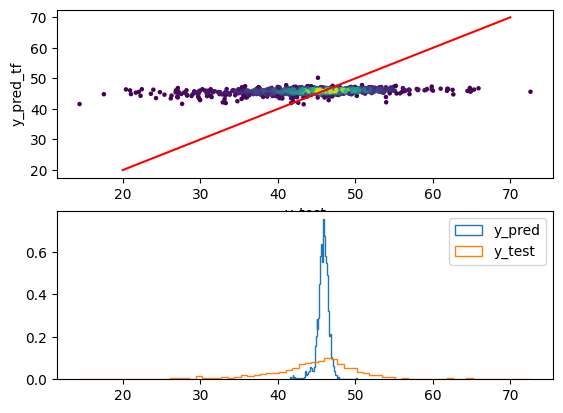

In [72]:
x = np.linspace(20,70,100)
y = x

# Calculate the point density
xy = np.vstack([y_test_tf.reshape(-1),y_pred_tf.reshape(-1)])
z = gaussian_kde(xy)(xy)


fig, axs = plt.subplots(2)
axs[0].scatter(y_test_tf,y_pred_tf, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_test')
axs[0].set_ylabel('y_pred_tf')
axs[1].hist(y_pred_tf, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_test_tf,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()

# Optimize TensorFlow using Random search

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
# specify parameters and distributions to sample from
parameters_RandomSearch = {"epochs": randint(10, 60),
                           "batch_size": randint(100,2000),
                           #"n_hidden1": (10,500),
                           #"n_hidden2": (10,500),
                           #"n_hidden3": (10,500),
                          }

In [ ]:
# run randomized search
n_iter_search = 9
RandomSearch_tf = RandomizedSearchCV(clf,
                                  param_distributions=parameters_RandomSearch,
                                  n_iter=n_iter_search,
                                  cv=5,
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [76]:
# fit the random search instance
RandomSearch_tf.fit(X_train, y_train);

Epoch 1/38


/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3193
Epoch 2/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3148
Epoch 3/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3103
Epoch 4/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3056
Epoch 5/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3009
Epoch 6/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2959
Epoch 7/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2909
Epoch 8/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2857
Epoch 9/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2803
Epoch 10/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2748
Epoch 11/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2690
Epoch 12/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2629
Epoch 13/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2566
Epoch 14/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2502
Epoch 15/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2433
Epoch 16/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3216
Epoch 2/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3164
Epoch 3/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3112
Epoch 4/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3063
Epoch 5/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3010
Epoch 6/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2956
Epoch 7/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2898
Epoch 8/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2845
Epoch 9/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2784
Epoch 10/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2725
Epoch 11/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2668
Epoch 12/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2604
Epoch 13/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2536
Epoch 14/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2468
Epoch 15/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2400
Epoch 16/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3226
Epoch 2/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3183
Epoch 3/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3139
Epoch 4/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3092
Epoch 5/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3044
Epoch 6/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2993
Epoch 7/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2937
Epoch 8/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2882
Epoch 9/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2826
Epoch 10/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2769
Epoch 11/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2711
Epoch 12/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2650
Epoch 13/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2590
Epoch 14/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2527
Epoch 15/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2466
Epoch 16/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3220
Epoch 2/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3164
Epoch 3/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3120
Epoch 4/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3070
Epoch 5/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3022
Epoch 6/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2972
Epoch 7/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2917
Epoch 8/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2862
Epoch 9/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2802
Epoch 10/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2740
Epoch 11/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2674
Epoch 12/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2611
Epoch 13/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2547
Epoch 14/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2483
Epoch 15/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2420
Epoch 16/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3221
Epoch 2/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3152
Epoch 3/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3104
Epoch 4/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3057
Epoch 5/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3009
Epoch 6/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2959
Epoch 7/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2907
Epoch 8/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2852
Epoch 9/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2796
Epoch 10/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2739
Epoch 11/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2683
Epoch 12/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2625
Epoch 13/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2565
Epoch 14/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2504
Epoch 15/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2442
Epoch 16/38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3182
Epoch 2/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3122
Epoch 3/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3064
Epoch 4/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3010
Epoch 5/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2963
Epoch 6/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2918
Epoch 7/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2865
Epoch 8/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2815
Epoch 9/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2764
Epoch 10/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2713
Epoch 11/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2657
Epoch 12/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2601
Epoch 13/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2548
Epoch 14/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2487
Epoch 15/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2424
Epoch 16/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3217
Epoch 2/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3171
Epoch 3/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3125
Epoch 4/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3072
Epoch 5/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3015
Epoch 6/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2960
Epoch 7/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2915
Epoch 8/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2865
Epoch 9/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2814
Epoch 10/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2760
Epoch 11/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2705
Epoch 12/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2649
Epoch 13/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2594
Epoch 14/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2534
Epoch 15/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2474
Epoch 16/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3280
Epoch 2/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3181
Epoch 3/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3130
Epoch 4/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3078
Epoch 5/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3025
Epoch 6/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2970
Epoch 7/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2915
Epoch 8/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2861
Epoch 9/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2803
Epoch 10/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2744
Epoch 11/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2684
Epoch 12/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2622
Epoch 13/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2559
Epoch 14/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2494
Epoch 15/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2428
Epoch 16/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3252
Epoch 2/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3182
Epoch 3/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3132
Epoch 4/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3085
Epoch 5/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3039
Epoch 6/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2992
Epoch 7/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2944
Epoch 8/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2893
Epoch 9/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2841
Epoch 10/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2788
Epoch 11/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2734
Epoch 12/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2675
Epoch 13/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2614
Epoch 14/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2550
Epoch 15/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2484
Epoch 16/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3201
Epoch 2/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3142
Epoch 3/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3089
Epoch 4/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3041
Epoch 5/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2992
Epoch 6/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2946
Epoch 7/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2898
Epoch 8/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2846
Epoch 9/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2792
Epoch 10/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2737
Epoch 11/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2681
Epoch 12/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2623
Epoch 13/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2564
Epoch 14/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2504
Epoch 15/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2445
Epoch 16/52
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3190
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3133
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3083
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3028
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2974
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2922
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2869
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2815
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2759
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2701
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2643
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2585
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2523
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2463
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2398
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3211
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3152
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3102
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3052
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2998
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2943
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2890
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2837
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2781
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2725
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2673
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2612
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2552
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2493
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2431
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3228
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3172
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3122
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3074
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3025
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2978
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2928
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2876
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2821
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2764
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2706
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2646
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2585
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2522
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2455
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3218
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3171
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3127
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3081
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3032
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2976
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2920
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2862
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2806
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2746
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2685
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2619
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2552
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2483
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2413
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3211
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3155
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3110
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3062
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3017
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2969
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2920
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2872
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2819
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2765
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2709
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2650
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2589
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2528
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2464
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3198
Epoch 2/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3164
Epoch 3/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3127
Epoch 4/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3089
Epoch 5/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3049
Epoch 6/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3011
Epoch 7/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2976
Epoch 8/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2940
Epoch 9/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2906
Epoch 10/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2874
Epoch 11/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2839
Epoch 12/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2804
Epoch 13/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2766
Epoch 14/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2731
Epoch 15/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2694
Epoch 16/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3211
Epoch 2/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3172
Epoch 3/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3135
Epoch 4/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3100
Epoch 5/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3066
Epoch 6/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3032
Epoch 7/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2998
Epoch 8/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2964
Epoch 9/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2932
Epoch 10/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2897
Epoch 11/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2862
Epoch 12/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2825
Epoch 13/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2789
Epoch 14/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2752
Epoch 15/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2713
Epoch 16/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3237
Epoch 2/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3199
Epoch 3/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3165
Epoch 4/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3133
Epoch 5/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3101
Epoch 6/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3068
Epoch 7/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3036
Epoch 8/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3002
Epoch 9/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2967
Epoch 10/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2930
Epoch 11/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2894
Epoch 12/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2856
Epoch 13/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2818
Epoch 14/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2780
Epoch 15/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2739
Epoch 16/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3223
Epoch 2/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3183
Epoch 3/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3145
Epoch 4/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3106
Epoch 5/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3066
Epoch 6/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3027
Epoch 7/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2985
Epoch 8/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2942
Epoch 9/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2899
Epoch 10/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2861
Epoch 11/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2822
Epoch 12/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2783
Epoch 13/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2743
Epoch 14/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2703
Epoch 15/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2661
Epoch 16/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3225
Epoch 2/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3185
Epoch 3/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3149
Epoch 4/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3115
Epoch 5/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3081
Epoch 6/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3047
Epoch 7/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3011
Epoch 8/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2974
Epoch 9/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2937
Epoch 10/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2901
Epoch 11/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2865
Epoch 12/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2833
Epoch 13/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2796
Epoch 14/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2758
Epoch 15/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2721
Epoch 16/28
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3196
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3138
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3077
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3016
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2962
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2914
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2860
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2806
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2752
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2698
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2639
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2580
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2519
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2458
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2395
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3199
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3135
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3092
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3048
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3001
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2956
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2908
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2861
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2809
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2757
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2705
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2649
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2593
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2536
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2477
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3226
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3181
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3135
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3085
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3033
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2982
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2928
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2873
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2816
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2755
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2693
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2627
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2561
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2494
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2425
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3211
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3153
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3103
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3053
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3002
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2949
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2893
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2836
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2774
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2711
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2647
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2583
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2518
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2454
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2387
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3227
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3170
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3117
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3063
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2954
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2897
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2839
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2780
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2719
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2656
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2592
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2528
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2457
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2391
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3191
Epoch 2/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3152
Epoch 3/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3119
Epoch 4/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3087
Epoch 5/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3053
Epoch 6/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3020
Epoch 7/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2986
Epoch 8/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2950
Epoch 9/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2915
Epoch 10/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2880
Epoch 11/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2844
Epoch 12/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2807
Epoch 13/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2770
Epoch 14/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2731
Epoch 15/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2692
Epoch 16/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3234
Epoch 2/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3189
Epoch 3/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3152
Epoch 4/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3114
Epoch 5/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3077
Epoch 6/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3042
Epoch 7/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3010
Epoch 8/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2977
Epoch 9/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2941
Epoch 10/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2903
Epoch 11/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2869
Epoch 12/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2833
Epoch 13/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2796
Epoch 14/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2760
Epoch 15/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2722
Epoch 16/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3229
Epoch 2/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3193
Epoch 3/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3161
Epoch 4/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3129
Epoch 5/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3097
Epoch 6/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3064
Epoch 7/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3030
Epoch 8/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2995
Epoch 9/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2959
Epoch 10/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2923
Epoch 11/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2886
Epoch 12/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2847
Epoch 13/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2808
Epoch 14/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2768
Epoch 15/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2728
Epoch 16/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3208
Epoch 2/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3151
Epoch 3/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3109
Epoch 4/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3072
Epoch 5/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3038
Epoch 6/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3008
Epoch 7/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2976
Epoch 8/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2946
Epoch 9/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2914
Epoch 10/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2882
Epoch 11/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2849
Epoch 12/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2816
Epoch 13/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2782
Epoch 14/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2748
Epoch 15/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2712
Epoch 16/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3228
Epoch 2/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3184
Epoch 3/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3150
Epoch 4/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3117
Epoch 5/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3084
Epoch 6/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3051
Epoch 7/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3018
Epoch 8/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2985
Epoch 9/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2953
Epoch 10/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2918
Epoch 11/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2882
Epoch 12/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2845
Epoch 13/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2808
Epoch 14/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2770
Epoch 15/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2731
Epoch 16/33
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3195
Epoch 2/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3152
Epoch 3/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3114
Epoch 4/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3066
Epoch 5/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3016
Epoch 6/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2971
Epoch 7/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2925
Epoch 8/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2877
Epoch 9/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2826
Epoch 10/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2773
Epoch 11/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2719
Epoch 12/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2666
Epoch 13/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2610
Epoch 14/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2553
Epoch 15/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2500
Epoch 16/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3197
Epoch 2/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3135
Epoch 3/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3089
Epoch 4/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3047
Epoch 5/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3012
Epoch 6/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2977
Epoch 7/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2928
Epoch 8/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2873
Epoch 9/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2826
Epoch 10/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2778
Epoch 11/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2726
Epoch 12/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2673
Epoch 13/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2626
Epoch 14/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2577
Epoch 15/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2524
Epoch 16/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3214
Epoch 2/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3161
Epoch 3/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3119
Epoch 4/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3072
Epoch 5/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3025
Epoch 6/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2980
Epoch 7/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2935
Epoch 8/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2885
Epoch 9/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2831
Epoch 10/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2778
Epoch 11/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2725
Epoch 12/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2675
Epoch 13/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2625
Epoch 14/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2573
Epoch 15/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2518
Epoch 16/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3214
Epoch 2/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3143
Epoch 3/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3094
Epoch 4/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3047
Epoch 5/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2998
Epoch 6/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2953
Epoch 7/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2920
Epoch 8/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2870
Epoch 9/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2807
Epoch 10/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2751
Epoch 11/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2708
Epoch 12/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2662
Epoch 13/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2607
Epoch 14/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2546
Epoch 15/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2491
Epoch 16/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3237
Epoch 2/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3180
Epoch 3/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3141
Epoch 4/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3104
Epoch 5/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3063
Epoch 6/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3020
Epoch 7/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2978
Epoch 8/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2934
Epoch 9/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2891
Epoch 10/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2848
Epoch 11/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2802
Epoch 12/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2758
Epoch 13/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2713
Epoch 14/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2664
Epoch 15/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2611
Epoch 16/45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3192
Epoch 2/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3125 
Epoch 3/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3064
Epoch 4/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3001 
Epoch 5/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2934
Epoch 6/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2866
Epoch 7/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2789
Epoch 8/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2713
Epoch 9/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2624
Epoch 10/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2536
Epoch 11/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2446
Epoch 12/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2358 
Epoch 13/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2270 
Epoch 14/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2181
Epoch 15/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2086 
Epoch 16/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3215
Epoch 2/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3159
Epoch 3/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3093
Epoch 4/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3016
Epoch 5/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2950 
Epoch 6/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2890
Epoch 7/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2826 
Epoch 8/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2756 
Epoch 9/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2690
Epoch 10/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2617
Epoch 11/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2538
Epoch 12/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2456
Epoch 13/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2369
Epoch 14/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2287
Epoch 15/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2194
Epoch 16/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3214
Epoch 2/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3145
Epoch 3/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3081
Epoch 4/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3022
Epoch 5/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2952
Epoch 6/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2880
Epoch 7/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2808 
Epoch 8/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2733 
Epoch 9/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2660 
Epoch 10/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2582
Epoch 11/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2500 
Epoch 12/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2423 
Epoch 13/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2343
Epoch 14/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2253
Epoch 15/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2172 
Epoch 16/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3205
Epoch 2/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3133 
Epoch 3/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3069 
Epoch 4/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2996 
Epoch 5/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2930
Epoch 6/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2867
Epoch 7/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2801
Epoch 8/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2730
Epoch 9/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2657
Epoch 10/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2585
Epoch 11/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2510
Epoch 12/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2426
Epoch 13/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2348
Epoch 14/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2261
Epoch 15/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2173 
Epoch 16/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3219
Epoch 2/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3147
Epoch 3/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3076
Epoch 4/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3004
Epoch 5/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2929
Epoch 6/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2857
Epoch 7/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2786 
Epoch 8/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2710 
Epoch 9/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2628
Epoch 10/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2542
Epoch 11/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2457 
Epoch 12/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2371
Epoch 13/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2282
Epoch 14/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2191 
Epoch 15/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2102 
Epoch 16/33
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3106
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2886 
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2637 
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2349 
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2031 
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1705 
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0920 
Epoch 10/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0781 
Epoch 11/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0702 
Epoch 12/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0673 
Epoch 13/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0652 
Epoch 14/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0644 
Epoch 15/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0644 
Epoch 16/31
14/1

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3128
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2880 
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2348 
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2039 
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1721 
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1412 
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1144 
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0941 
Epoch 10/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0795 
Epoch 11/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0709 
Epoch 12/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0674 
Epoch 13/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 
Epoch 14/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0668 
Epoch 15/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654 
Epoch 16/31
14/1

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3134
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2879 
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2618 
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2328 
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2022 
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1704 
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1398 
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1138 
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0932 
Epoch 10/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783 
Epoch 11/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 
Epoch 12/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0675 
Epoch 13/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655 
Epoch 14/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0648 
Epoch 15/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0655 
Epoch 16/31
14/1

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3126
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2877 
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2599 
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2303 
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1983 
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1665 
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1358 
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1098 
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0899 
Epoch 10/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0769 
Epoch 11/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0710 
Epoch 12/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0670 
Epoch 13/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0666 
Epoch 14/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0657 
Epoch 15/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655 
Epoch 16/31
14/1

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3128
Epoch 2/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2871 
Epoch 3/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2593 
Epoch 4/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2298 
Epoch 5/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1977 
Epoch 6/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1658 
Epoch 7/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1363 
Epoch 8/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1112 
Epoch 9/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0912 
Epoch 10/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0790 
Epoch 11/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0714 
Epoch 12/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0670 
Epoch 13/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0656 
Epoch 14/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0662 
Epoch 15/31
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0656 
Epoch 16/31
14/1

/home/admin_ml/Jackson/projects/Data-Science-Project-Diary/physics/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3115
Epoch 2/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2844 
Epoch 3/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2532 
Epoch 4/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2162 
Epoch 5/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1765 
Epoch 6/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 
Epoch 7/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1077 
Epoch 8/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0848 
Epoch 9/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723 
Epoch 10/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0671 
Epoch 11/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0654 
Epoch 12/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0646 
Epoch 13/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0647 
Epoch 14/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0648 
Epoch 15/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0652 
Epoch 16/31
17/1

In [79]:
RandomSearch_results_tf = pd.DataFrame(RandomSearch_tf.cv_results_)
print("Random Search: \tBest parameters: ", RandomSearch_tf.best_params_, f", Best scores: {RandomSearch_tf.best_score_:.3f}")


Random Search: 	Best parameters:  {'batch_size': 230, 'epochs': 31} , Best scores: 0.095


In [80]:
tf_RandomSearch = RandomSearch_tf.best_estimator_
# Make predictions:
y_pred_tf_rand_opt_norm = tf_RandomSearch.predict(X_test)

#Renormalize
y_pred_tf_rand_opt = qt.inverse_transform(y_pred_tf_rand_opt_norm.reshape(-1, 1))

# accuracy check
mse_tf_rand_opt = mean_squared_error(y_test_tf, y_pred_tf_rand_opt)
rmse_tf_rand_opt = mse_tf_rand_opt**(0.5)


print(f'RMSE LightGBM no optimization: {rmse:.4f}')
print(f'RMSE LightGBM Random Search: {rmse_lgb_rand_opt:.4f}')
print(f'RMSE TensorFlow no optimization: {rmse_tf:.4f}')
print(f'RMSE TensorFlow Random Search: {rmse_tf_rand_opt:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RMSE LightGBM no optimization: 5.2325
RMSE LightGBM Random Search: 5.1717
RMSE TensorFlow no optimization: 6.2998
RMSE TensorFlow Random Search: 6.0989
